In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00


In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA


In [4]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


In [5]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [6]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [7]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [8]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    return acc

In [9]:
models = {
    "GCN": GCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes),
    "GraphSAGE": GraphSAGE(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes),
    "GAT": GAT(in_channels=dataset.num_features, hidden_channels=8, out_channels=dataset.num_classes, heads=8)
}

optimizers = {
    "GCN": torch.optim.Adam(models["GCN"].parameters(), lr=0.01, weight_decay=5e-4),
    "GraphSAGE": torch.optim.Adam(models["GraphSAGE"].parameters(), lr=0.01, weight_decay=5e-4),
    "GAT": torch.optim.Adam(models["GAT"].parameters(), lr=0.005, weight_decay=5e-4)
}

for model_name, model in models.items():
    optimizer = optimizers[model_name]

    for epoch in range(200):
        loss = train(model, optimizer, data)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

    test_acc = test(model, data)
    print(f'Test Accuracy: {test_acc:.4f}')

    print(f"Training {model_name} Model:")
    print("Activation Functions: ", "ReLU, Log Softmax" if model_name in ["GCN", "GraphSAGE"] else "ELU, Log Softmax")
    print(f"Loss Function: {F.nll_loss.__name__}")
    print(f"Optimizer: Adam (lr={optimizer.param_groups[0]['lr']}, weight_decay={optimizer.param_groups[0]['weight_decay']})\n")

Epoch 10, Loss: 0.8533
Epoch 20, Loss: 0.2351
Epoch 30, Loss: 0.1117
Epoch 40, Loss: 0.0963
Epoch 50, Loss: 0.0438
Epoch 60, Loss: 0.0437
Epoch 70, Loss: 0.0405
Epoch 80, Loss: 0.0446
Epoch 90, Loss: 0.0423
Epoch 100, Loss: 0.0396
Epoch 110, Loss: 0.0495
Epoch 120, Loss: 0.0396
Epoch 130, Loss: 0.0315
Epoch 140, Loss: 0.0538
Epoch 150, Loss: 0.0429
Epoch 160, Loss: 0.0426
Epoch 170, Loss: 0.0320
Epoch 180, Loss: 0.0285
Epoch 190, Loss: 0.0281
Epoch 200, Loss: 0.0288
Test Accuracy: 0.7950
Training GCN Model:
Activation Functions:  ReLU, Log Softmax
Loss Function: nll_loss
Optimizer: Adam (lr=0.01, weight_decay=0.0005)

Epoch 10, Loss: 0.3784
Epoch 20, Loss: 0.0596
Epoch 30, Loss: 0.0175
Epoch 40, Loss: 0.0201
Epoch 50, Loss: 0.0166
Epoch 60, Loss: 0.0095
Epoch 70, Loss: 0.0357
Epoch 80, Loss: 0.0177
Epoch 90, Loss: 0.0185
Epoch 100, Loss: 0.0286
Epoch 110, Loss: 0.0211
Epoch 120, Loss: 0.0158
Epoch 130, Loss: 0.0216
Epoch 140, Loss: 0.0222
Epoch 150, Loss: 0.0131
Epoch 160, Loss: 0.0146

In [14]:
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()
        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])
        precision = precision_score(y_true[data.test_mask], y_pred[data.test_mask], average='weighted')
        recall = recall_score(y_true[data.test_mask], y_pred[data.test_mask], average='weighted')
        f1 = f1_score(y_true[data.test_mask], y_pred[data.test_mask], average='weighted')
        return accuracy, precision, recall, f1

In [11]:
model_gcn = models["GCN"]
model_graphsage = models["GraphSAGE"]
model_gat = models["GAT"]

metrics_gcn = evaluate_model(model_gcn, data)
metrics_graphsage = evaluate_model(model_graphsage, data)
metrics_gat = evaluate_model(model_gat, data)

results = {
    'GCN': metrics_gcn,
    'GraphSAGE': metrics_graphsage,
    'GAT': metrics_gat
}


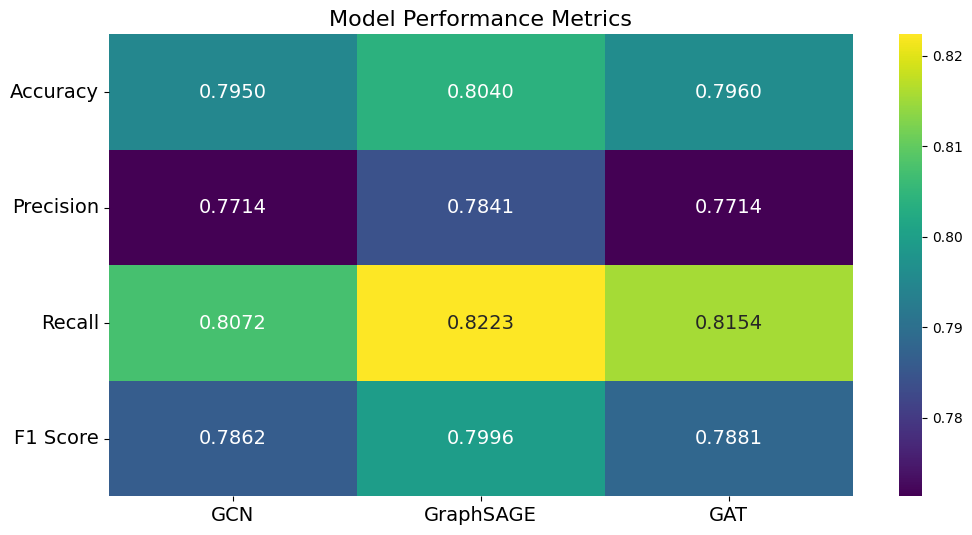

In [16]:
def evaluate_metrics(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

metrics = {
    "GCN": evaluate_metrics(models["GCN"], data),
    "GraphSAGE": evaluate_metrics(models["GraphSAGE"], data),
    "GAT": evaluate_metrics(models["GAT"], data)
}

metrics_df = pd.DataFrame(metrics, index=["Accuracy", "Precision", "Recall", "F1 Score"])

plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df, annot=True, cmap="viridis", cbar=True, fmt=".4f", annot_kws={"size": 14})
plt.title("Model Performance Metrics", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, rotation=0)
plt.show()


In [13]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x = data.x
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = MLP(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    loss = train(model, optimizer, data)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

test_acc = test(model, data)
print(f'MLP Test Accuracy: {test_acc:.4f}')

Epoch 10, Loss: 1.1168
Epoch 20, Loss: 0.5635
Epoch 30, Loss: 0.3027
Epoch 40, Loss: 0.2508
Epoch 50, Loss: 0.2471
Epoch 60, Loss: 0.2138
Epoch 70, Loss: 0.2145
Epoch 80, Loss: 0.2430
Epoch 90, Loss: 0.2858
Epoch 100, Loss: 0.1663
Epoch 110, Loss: 0.1972
Epoch 120, Loss: 0.1871
Epoch 130, Loss: 0.1818
Epoch 140, Loss: 0.2600
Epoch 150, Loss: 0.1832
Epoch 160, Loss: 0.2075
Epoch 170, Loss: 0.1839
Epoch 180, Loss: 0.1874
Epoch 190, Loss: 0.1513
Epoch 200, Loss: 0.1921
MLP Test Accuracy: 0.5980


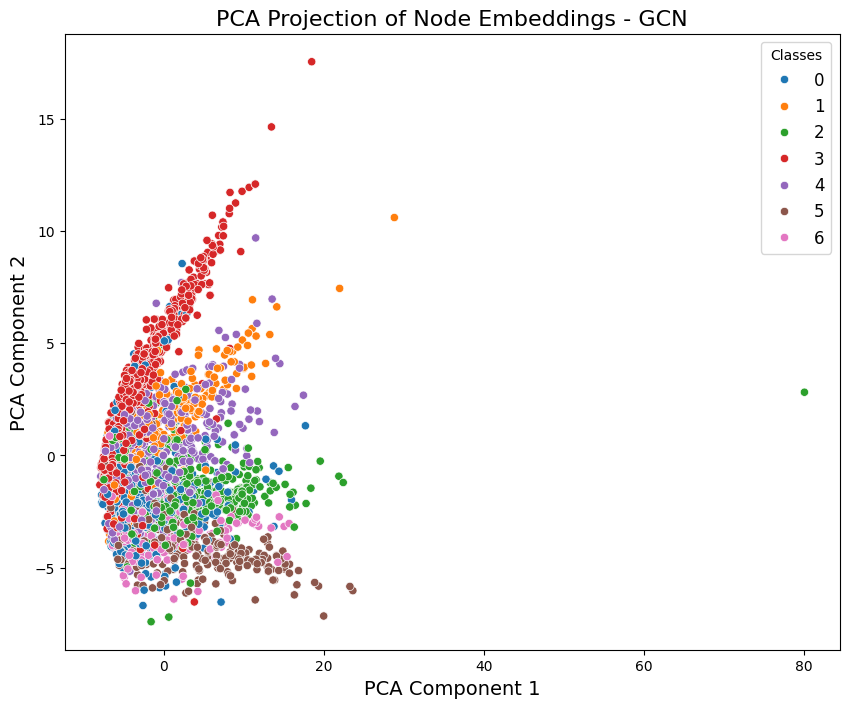

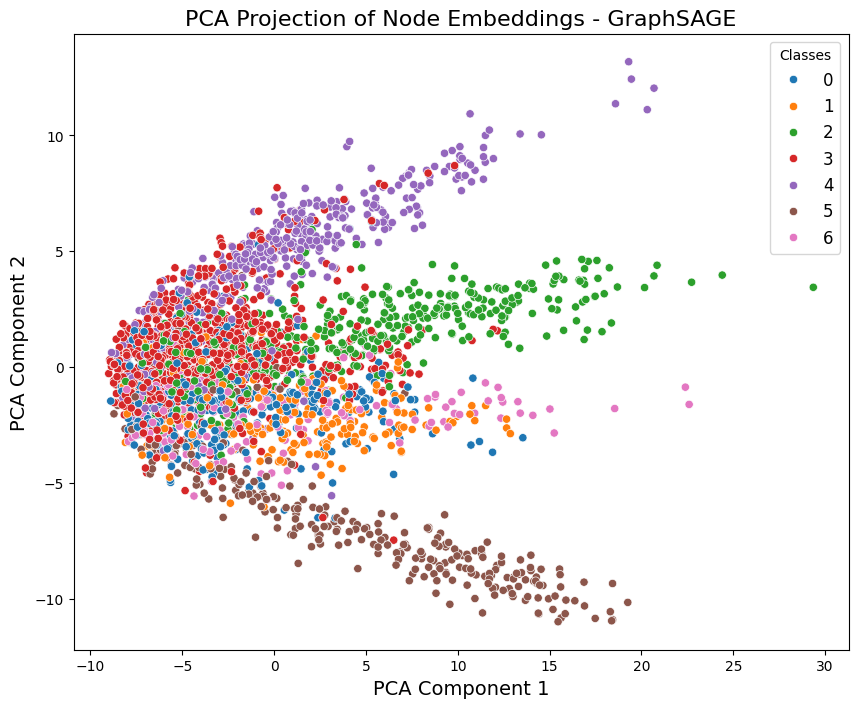

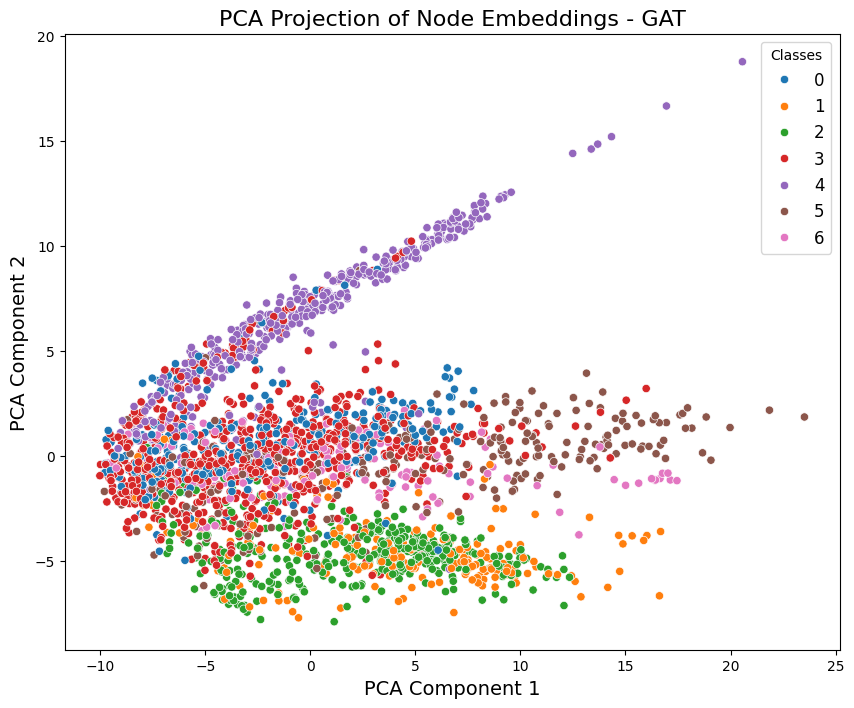

In [21]:
def visualize_embeddings(model, data, title):
    model.eval()
    with torch.no_grad():
        embeddings = model(data).detach()
        embeddings = embeddings.cpu().numpy()

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    labels = data.y.cpu().numpy()

    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'label': labels
    })

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x='x', y='y', hue='label', palette='tab10', legend='full')
    plt.title(f'PCA Projection of Node Embeddings - {title}', fontsize=16)
    plt.xlabel('PCA Component 1', fontsize=14)
    plt.ylabel('PCA Component 2', fontsize=14)
    plt.legend(title='Classes', fontsize=12)
    plt.show()

for model_name, model in models.items():
    visualize_embeddings(model, data, model_name)
